# 1. Import Datasets

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

Using TensorFlow backend.


In [2]:
#function to load the dataset
def load_dataset(path):
    data = load_files(path)
    fish_files = np.array(data['filenames'])
    fish_target = np_utils.to_categorical(np.array(data['target']), 8)
    return fish_files,fish_target

In [3]:
#loading the paths of training set
train_files, train_targets = load_dataset('fishImages/train')

#loading the paths of testing set
test_files, _ = load_dataset('fishImages/test')

#printing the number of samples in test and trainig sets.
print ("There are %d images in training dataset"%len(train_files))
print ("There are %d images in the training set"%len(test_files))

There are 3777 images in training dataset
There are 13153 images in the training set


# 2. Visualizations


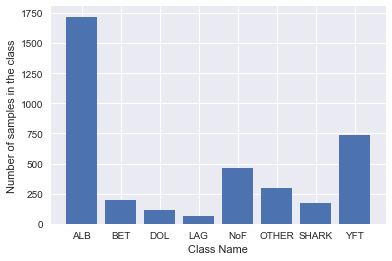

In [57]:
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

sns.set(color_codes=True)

#finding the number of samles in each class
[ALB, BET, DOL, LAG, NoF, OTHER, SHARK, YFT] = sum(train_targets)


fish_count =[ALB, BET, DOL, LAG, NoF, OTHER, SHARK, YFT]

x=np.arange(8)

#plotting the barplot between name of classes and number of samples in each class 
fig, ax = plt.subplots()
plt.bar(x, fish_count)
plt.xticks(x, ('ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'))
plt.xlabel("Class Name")
plt.ylabel("Number of samples in the class")
plt.show()

Histogram for color Internsity of the image below:


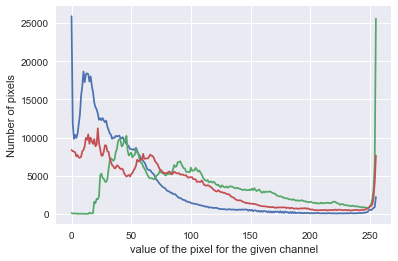

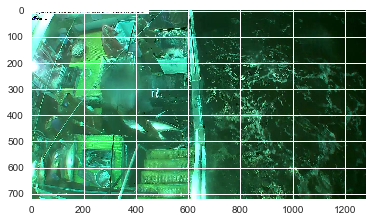

Size of the image - (720 , 1280)
----------------------------------------------------------------------------------------------------
Histogram for color Internsity of the image below:


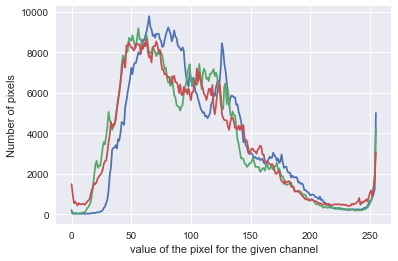

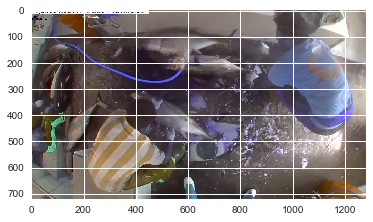

Size of the image - (720 , 1280)
----------------------------------------------------------------------------------------------------
Histogram for color Internsity of the image below:


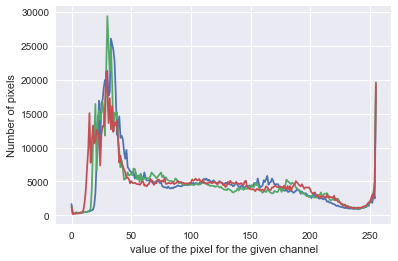

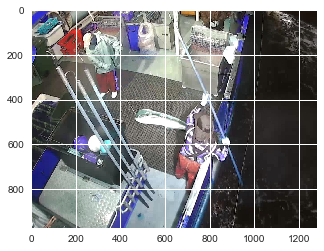

Size of the image - (974 , 1280)
----------------------------------------------------------------------------------------------------
Histogram for color Internsity of the image below:


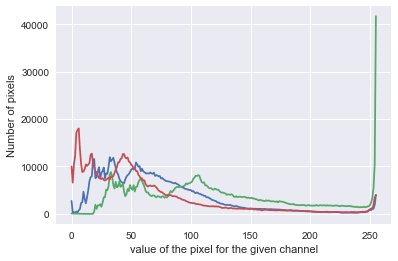

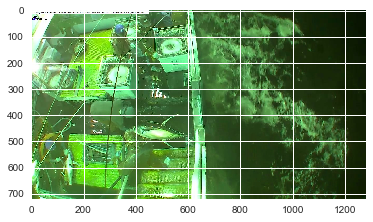

Size of the image - (720 , 1280)
----------------------------------------------------------------------------------------------------


In [58]:
#function for plotting a histogram for the color intensity of an image

def intensity_dist(path):
    #reading the image from its path
    img = cv2.imread(path)
    color = ('b','g','r')
    #calculating the number of pixels of each color
    for i, col in enumerate(color):
        histr = cv2.calcHist([img], [i], None, [256], [0,256])
        plt.plot(histr, color=col)
    print("Histogram for color Internsity of the image below:")
    
    #showing the histogram
    plt.xlabel("value of the pixel for the given channel")
    plt.ylabel("Number of pixels")
    plt.show()
    
    #showing the image
    plt.imshow(img)
    plt.show()
    height, width, channels = img.shape
    print("Size of the image - (%d , %d)"%(height,width)) 
    print("-"*100)
    
intensity_dist(train_files[56])
intensity_dist(train_files[667])
intensity_dist(train_files[660])
intensity_dist(train_files[1547])


Histogram for color Internsity of the image below:


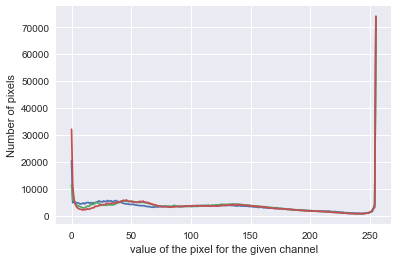

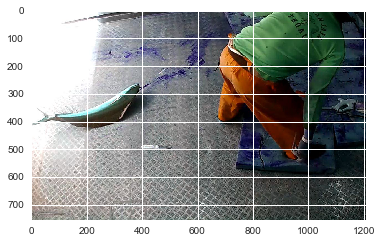

Size of the image - (755 , 1208)
----------------------------------------------------------------------------------------------------


In [76]:
#intensity_dist(train_files[1147])
#intensity_dist(test_files[12455])
intensity_dist(test_files[60])

# 3. Data pre-processing

In [4]:
from keras.preprocessing import image
from tqdm import tqdm

#converting image to tensor
def path_to_tensor(img_path):
    # loads RGB image
    img = image.load_img(img_path, target_size=(224,224))
    #convering the image to 3-D tensor with shape (224,224,3)
    x = image.img_to_array(img)
    #convert 3D tensor to 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 

#preprocessing the data
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████| 13153/13153 [06:27<00:00, 30.51it/s]


In [ ]:
train_tensors = paths_to_tensor(train_files).astype('float32')/255

100%|██████████████████████████████████████████████████████████████████████████████| 3777/3777 [03:58<00:00, 18.74it/s]


In [8]:
#shape of the tensor
print(np.shape(train_tensors))

(3777, 224, 224, 3)


# 4. Creating Benchmark Model

In [87]:
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Sequential

benchmark = Sequential()

# model Convolution layer
benchmark.add(Conv2D(filters=16,kernel_size=2,strides=1,activation='relu',input_shape=(224,224,3)))
# Max Pooling layer to reduce the dimensionality
benchmark.add(MaxPooling2D(pool_size=2,strides=2))
#Dropout layer, for turning off each node with the probability of 0.3
benchmark.add(Dropout(0.3))
benchmark.add(Conv2D(filters=32, kernel_size=2,strides=1,activation='relu'))
benchmark.add(Dropout(0.3))
benchmark.add(GlobalAveragePooling2D())
#A fully connected dense layer with 8 nodes (no of classes of fish)
benchmark.add(Dense(8,activation='softmax'))
benchmark.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 110, 110, 32)      2080      
_________________________________________________________________
dropout_16 (Dropout)         (None, 110, 110, 32)      0         
_________________________________________________________________
global_average_pooling2d_9 ( (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 264       
Total para

### Compiling the Model

In [88]:
benchmark.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [89]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


epochs = 5

#checkpointer saves the best weights.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.benchmark.hdf5', verbose=1, save_best_only=True)

benchmark.fit(train_tensors, train_targets, batch_size=20, epochs=epochs, callbacks=[checkpointer], validation_split=0.2, verbose=1)

Train on 3021 samples, validate on 756 samples
Epoch 1/5
3021/3021 [==============================] - 219s - loss: 1.6586 - acc: 0.4369 - val_loss: 1.5983 - val_acc: 0.4643
Epoch 2/5
3021/3021 [==============================] - 229s - loss: 1.5800 - acc: 0.4522 - val_loss: 1.5988 - val_acc: 0.4643
Epoch 3/5
3021/3021 [==============================] - 226s - loss: 1.5659 - acc: 0.4585 - val_loss: 1.6037 - val_acc: 0.4590
Epoch 4/5
3021/3021 [==============================] - 230s - loss: 1.5558 - acc: 0.4558 - val_loss: 1.5602 - val_acc: 0.4788
Epoch 5/5
3021/3021 [==============================] - 228s - loss: 1.5500 - acc: 0.4585 - val_loss: 1.5524 - val_acc: 0.4788


# 5. Making Predictions for Benchmark

### Loading the  weights of Benchmark model

In [90]:
benchmark.load_weights('saved_models/weights.best.benchmark.hdf5')

### Predictions

In [91]:
benchmark_model_prediction = [benchmark.predict(np.expand_dims(img_tensor, axis=0)) for img_tensor in test_tensors]

### Processing the Predictions

In [92]:
#visaulizing the array
print(benchmark_model_prediction[:][0])

[[ 0.49615744  0.06079777  0.02502432  0.01484601  0.0548594   0.09189517
   0.07191775  0.18450215]]


In [93]:
#swapping the axes of the benchmark_model_prediction for easy handling
benchmark_model_prediction = np.swapaxes(benchmark_model_prediction,0,1)

#creating a pandas dataframe for with benchmark model's prediction
df_pred_model1 = pd.DataFrame(benchmark_model_prediction[0][:], columns=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'])

#first five rows of df_pred_model1 dataframe
print(df_pred_model1[:5])

        ALB       BET       DOL       LAG       NoF     OTHER     SHARK  \
0  0.496157  0.060798  0.025024  0.014846  0.054859  0.091895  0.071918   
1  0.538152  0.061293  0.029150  0.016751  0.170454  0.053727  0.022819   
2  0.507530  0.063027  0.031525  0.019159  0.203895  0.055174  0.021770   
3  0.560656  0.063736  0.027445  0.016403  0.144184  0.056134  0.026291   
4  0.524980  0.063282  0.030473  0.018095  0.179656  0.055324  0.023355   

        YFT  
0  0.184502  
1  0.107653  
2  0.097920  
3  0.105151  
4  0.104835  


In [94]:
#extracting name of the image form its path
image_names = [test_files[i][22:] for i in range(len(test_files))]


#adjusting the filename of the image to match the submission guidelines
for i in range(13153):
    if image_names[i][5]=='_':
        image_names[i] = "test_stg2/" + image_names[i]

In [95]:
#adding image names to our dataframe
df_pred_model1['image'] = pd.DataFrame(image_names)

#reindexing the dataframe
df_pred_model1 = df_pred_model1.reindex_axis(['image','ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'], axis=1)

#printing the first five rows of dataframe
print(df_pred_model1[:5])

                       image       ALB       BET       DOL       LAG  \
0  test_stg2/image_10973.jpg  0.496157  0.060798  0.025024  0.014846   
1  test_stg2/image_00175.jpg  0.538152  0.061293  0.029150  0.016751   
2  test_stg2/image_09645.jpg  0.507530  0.063027  0.031525  0.019159   
3              img_02920.jpg  0.560656  0.063736  0.027445  0.016403   
4  test_stg2/image_09349.jpg  0.524980  0.063282  0.030473  0.018095   

        NoF     OTHER     SHARK       YFT  
0  0.054859  0.091895  0.071918  0.184502  
1  0.170454  0.053727  0.022819  0.107653  
2  0.203895  0.055174  0.021770  0.097920  
3  0.144184  0.056134  0.026291  0.105151  
4  0.179656  0.055324  0.023355  0.104835  


### Generating .csv file for submission

In [96]:
df_pred_model1.to_csv('submission0.csv',index=False)

.


.


.





# Score Achieved by Model 1 - 2.00267


.


.


.




# 6. Model 2 (Using Transfer Learning, Extracted VGG-19 features)

In [16]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.layers import Input
import numpy as np

#Extracting the weights of VGG19 model pretrained on Imagenet
#defing the Input shape
input_tensor = Input(shape=(224,224,3))
#extracting the weights wof VGG19, without top layers
#and MaxPooling as pooling layer
base_model = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling=max)
#removing the last layer
output = base_model.get_layer(index = -1).output
#defining the model
VGG19_model2 = Model(base_model.input, output)
VGG19_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Extracting VGG19 features for training and testing datasets

In [57]:
VGG19_features = [VGG19_model2.predict(np.expand_dims(train_tensor, axis=0)) for train_tensor in train_tensors]

VGG19_features_test = [VGG19_model2.predict(np.expand_dims(test_tensor, axis=0)) for test_tensor in test_tensors]

In [108]:
print ("Shape of VGG_19_features: {0}".format(np.shape(VGG19_features)))

print ("Shape of VGG_19_features_test: {0}".format(np.shape(VGG19_features_test)))


Shape of VGG_19_features: (3777, 1, 7, 7, 512)
Shape of VGG_19_features_test: (13153, 1, 7, 7, 512)


### Pre-processing the features

In [110]:
#VGG_19_features having 5 dimensions, so we have to squeeze it to a 4 dim array by removing extra dimension
squeezed_VGG19_train = np.squeeze(VGG19_features, axis=1)
#squeezing the test features
squeezed_VGG19_test = np.squeeze(VGG19_features_test, axis=1)

print ("Shape of squeezed_VGG19_train: {0}".format(np.shape(squeezed_VGG19_train)))
print ("Shape of squeezed_VGG_19_test: {0}".format(np.shape(squeezed_VGG19_test)))


Shape of squeezed_VGG19_train: (3777, 7, 7, 512)
Shape of squeezed_VGG_19_test: (13153, 7, 7, 512)


### Defining the Model architecture

from keras.models import Sequential
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, Dense

fish_model = Sequential()
#adding a GlobalMaxPooling2D layer with with input shape same as the shape of Squeezed_VGG19_train.
fish_model.add(GlobalMaxPooling2D(input_shape=squeezed_VGG19_train.shape[1:]))
#adding a fully connected dense layer with relu activation function
fish_model.add(Dense(1024, activation='relu'))
#adding a dense layer with softmax activation function.
#no of nodes are same as the number of classes of fish.
fish_model.add(Dense(8, activation = 'softmax'))
fish_model.summary()

### Compiling the Model 2

In [136]:
#compiling the model with rmsprop optimizer
fish_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Training Model 2

In [137]:
#training fish_model on the trainig dataset
from keras.callbacks import ModelCheckpoint

#checkpointer for saving only best weights
checkpointer_VGG = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', verbose=1, save_best_only=True)

fish_model.fit(squeezed_VGG19_train,train_targets,validation_split=0.3,batch_size=20,
               epochs=5,callbacks=[checkpointer_VGG],verbose=1)

Train on 2643 samples, validate on 1134 samples
Epoch 1/5
2643/2643 [==============================] - 4s - loss: 0.2137 - acc: 0.9410 - val_loss: 0.3415 - val_acc: 0.8854
Epoch 2/5
2643/2643 [==============================] - 3s - loss: 0.1395 - acc: 0.9523 - val_loss: 0.2593 - val_acc: 0.9259
Epoch 3/5
2643/2643 [==============================] - 3s - loss: 0.1424 - acc: 0.9527 - val_loss: 0.2596 - val_acc: 0.9295
Epoch 4/5
2643/2643 [==============================] - 3s - loss: 0.1249 - acc: 0.9603 - val_loss: 0.3092 - val_acc: 0.9224
Epoch 5/5
2643/2643 [==============================] - 3s - loss: 0.0980 - acc: 0.9690 - val_loss: 0.2030 - val_acc: 0.9480


# 7. Making Predictions with Model 2

### Loading the weights 

In [ ]:
fish_model.load_weights('saved_models/weights.best.VGG19.hdf5')

### Prediction

In [ ]:
#making the predictions from fish_model
fish_model_prediction = [fish_model.predict(np.expand_dims(feature, axis=0)) for feature in squeezed_VGG19_test]

### Pre-processing the predictions

In [140]:
print(fish_model_prediction[1])

[[  6.80703461e-01   1.51917979e-04   1.88672189e-09   1.23345458e-07
    1.54403904e-02   9.27198096e-04   6.58480870e-03   2.96192110e-01]]


In [141]:
print(np.shape(fish_model_prediction))

(13153, 1, 8)


In [142]:
#swapping the axes for better handling
fish_model_prediction = np.swapaxes(fish_model_prediction,0,1)

In [143]:
import pandas as pd

#creating a pandas dataframe for with benchmark model's prediction
df_pred_fish_model = pd.DataFrame(fish_model_prediction[0][:], columns=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'])

In [144]:
print(df_pred_fish_model[:5])

        ALB           BET           DOL           LAG       NoF         OTHER  \
0  0.018720  4.602153e-06  7.228436e-11  3.400508e-07  0.002621  3.150908e-04   
1  0.680703  1.519180e-04  1.886722e-09  1.233455e-07  0.015440  9.271981e-04   
2  0.835605  1.847971e-07  6.018797e-08  2.611440e-06  0.162860  1.218202e-03   
3  0.999988  1.316302e-06  2.548765e-12  9.105020e-07  0.000009  5.856942e-07   
4  0.404770  8.544833e-06  6.318881e-12  6.559192e-11  0.591742  2.282362e-04   

          SHARK           YFT  
0  5.093942e-05  9.782884e-01  
1  6.584809e-03  2.961921e-01  
2  1.065201e-05  3.037542e-04  
3  2.187479e-13  3.602970e-08  
4  1.474776e-04  3.104093e-03  


In [145]:
#extracting name of the image form its path
image_names = [test_files[i][22:] for i in range(len(test_files))]


#adjusting the filename of the image to match the submission guidelines
for i in range(13153):
    if image_names[i][5]=='_':
        image_names[i] = "test_stg2/" + image_names[i]

In [146]:
#adding image names to our dataframe
df_pred_fish_model['image'] = pd.DataFrame(image_names)

#reindexing the dataframe
df_pred_fish_model = df_pred_fish_model.reindex_axis(['image','ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'], axis=1)

#printing the first five rows of dataframe
print(df_pred_fish_model[:5])

                       image       ALB           BET           DOL  \
0  test_stg2/image_10973.jpg  0.018720  4.602153e-06  7.228436e-11   
1  test_stg2/image_00175.jpg  0.680703  1.519180e-04  1.886722e-09   
2  test_stg2/image_09645.jpg  0.835605  1.847971e-07  6.018797e-08   
3              img_02920.jpg  0.999988  1.316302e-06  2.548765e-12   
4  test_stg2/image_09349.jpg  0.404770  8.544833e-06  6.318881e-12   

            LAG       NoF         OTHER         SHARK           YFT  
0  3.400508e-07  0.002621  3.150908e-04  5.093942e-05  9.782884e-01  
1  1.233455e-07  0.015440  9.271981e-04  6.584809e-03  2.961921e-01  
2  2.611440e-06  0.162860  1.218202e-03  1.065201e-05  3.037542e-04  
3  9.105020e-07  0.000009  5.856942e-07  2.187479e-13  3.602970e-08  
4  6.559192e-11  0.591742  2.282362e-04  1.474776e-04  3.104093e-03  


### Generating .csv file for submission

In [147]:
df_pred_fish_model.to_csv('submission2.csv',index=False)

.


.


.





# Score Achieved by Model 2 - 2.28866


.


.


.




# 8. Model-3 (Using less layers of VGG19)

In [29]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.layers import Input
import numpy as np

#Extracting the weights of VGG19 model pretrained on Imagenet
#defing the Input shape
input_tensor = Input(shape=(224,224,3))
#extracting the weights wof VGG19, without top layers
#and MaxPooling as pooling layer
base_model = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False, pooling=max)
#removing the last 11 layers
output = base_model.get_layer(index = -11).output
#defining the model
VGG19_model3 = Model(base_model.input, output)
VGG19_model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Extracting VGG19 features for training and testing datasets

In [12]:
VGG_19_features_2 = [VGG19_model3.predict(np.expand_dims(train_tensor, axis=0)) for train_tensor in train_tensors]

VGG_19_features_test_2 = [VGG19_model3.predict(np.expand_dims(test_tensor, axis=0)) for test_tensor in test_tensors]

### Pre-processing the features

In [36]:
squeezed_VGG19_train_2 = np.squeeze(VGG_19_features_2, axis=1)
print ("Shape of squeezed_VGG19_train_2: {0}".format(np.shape(squeezed_VGG19_train_2)))

MemoryError: 

## MEMORY ERROR

In [26]:
squeezed_VGG19_test_2 = np.squeeze(VGG_19_features_test_2, axis=1)

print ("Shape of squeezed_VGG_19_test_2: {0}".format(np.shape(squeezed_VGG19_test_2)))

MemoryError: 

### MEMORY ERROR

# 9. Model 4 (New Model From scratch)

In [42]:
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Sequential

model4 = Sequential()

# model Convolution layer
model4.add(Conv2D(filters=16,kernel_size=2,strides=1,activation='relu',input_shape=(224,224,3)))
# Max Pooling layer to reduce the dimensionality
model4.add(MaxPooling2D(pool_size=2,strides=2))
#Dropout layer, for turning off each node with the probability of 0.2
model4.add(Dropout(0.2))
model4.add(Conv2D(filters=32, kernel_size=2,strides=1,activation='relu'))
model4.add(MaxPooling2D(pool_size=2,strides=2))
model4.add(Dropout(0.2))
model4.add(Conv2D(filters=64,kernel_size=2,strides=1,activation='relu'))
model4.add(MaxPooling2D(pool_size=2,strides=2))
model4.add(Dropout(0.2))
model4.add(GlobalAveragePooling2D())
#A fully connected dense layer with 8 nodes (no of classes of fish)
model4.add(Dense(8,activation='softmax'))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 54, 54, 64)        8256      
__________

### Compiling the Model

In [43]:
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


epochs = 10

#checkpointer saves the weight of the best model only
checkpointer_4 = [EarlyStopping(monitor='val_loss',min_delta=0.01, patience=0, verbose=1), ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_6.hdf5',
                                  verbose=1, save_best_only=True)]

model4.fit(train_tensors, train_targets, batch_size=20, epochs=epochs, callbacks=checkpointer_4, validation_split=0.3, verbose=1)

Train on 2643 samples, validate on 1134 samples
Epoch 1/10
2643/2643 [==============================] - 261s - loss: 1.6396 - acc: 0.4578 - val_loss: 1.6458 - val_acc: 0.4480
Epoch 2/10
2643/2643 [==============================] - 201s - loss: 1.5744 - acc: 0.4665 - val_loss: 1.6449 - val_acc: 0.4497
Epoch 00001: early stopping


# 10. Making Predictions for Model 4

### Loading the  weights

In [30]:
#loading the weights of pretrained model
model4.load_weights('saved_models/weights.best.from_scratch_6.hdf5')

### Predictions

In [31]:
#making predictions
model4_prediction = [model4.predict(np.expand_dims(img_tensor, axis=0)) for img_tensor in test_tensors]

### Processing the Predictions

In [32]:
#swapping the axes of the model4_prediction for easy handling
model4_prediction = np.swapaxes(model4_prediction,0,1)

In [33]:
import pandas as pd

#creating a pandas dataframe for with benchmark model's prediction
df_pred_model4 = pd.DataFrame(model4_prediction[0][:], columns=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'])

In [34]:
#extracting name of the image form its path
image_names = [test_files[i][22:] for i in range(len(test_files))]


#adjusting the filename of the image to match the submission guidelines
for i in range(13153):
    if image_names[i][5]=='_':
        image_names[i] = "test_stg2/" + image_names[i]

In [35]:
#adding image names to our dataframe
df_pred_model4['image'] = pd.DataFrame(image_names)

#reindexing the dataframe
df_pred_model4 = df_pred_model4.reindex_axis(['image','ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'], axis=1)

### Generating .csv file for submission

In [36]:
df_pred_model4.to_csv('submission4.csv',index=False)

.


.


.





# Score Achieved by Model 4 - 1.65209


.


.


.




# 11. Model 5 (Refining Model 4)

In [55]:
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Sequential

model5 = Sequential()

#Model architecture.
#Convolution layer
model5.add(Conv2D(filters=32,kernel_size=2,strides=1,activation='relu',input_shape=(224,224,3)))
# Max Pooling layer to reduce the dimensionality
model5.add(MaxPooling2D(pool_size=2,strides=2))
#Dropout layer, for turning off each node with the probability of 0.5
model5.add(Dropout(0.5))
model5.add(Conv2D(filters=64, kernel_size=2,strides=1,activation='relu'))
model5.add(MaxPooling2D(pool_size=2,strides=2))
#Dropout layer, for turning off each node with the probability of 0.4
model5.add(Dropout(0.4))
model5.add(Conv2D(filters=128,kernel_size=2,strides=1,activation='relu'))
model5.add(MaxPooling2D(pool_size=2,strides=2))
#Dropout layer, for turning off each node with the probability of 0.2
model5.add(Dropout(0.2))
#Global Average Pooling layer for object localization
model5.add(GlobalAveragePooling2D())
#A fully connected dense layer with 8 nodes (no of classes of fish)
model5.add(Dense(8,activation='softmax'))
#printing the summary of the architecture
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 223, 223, 32)      416       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 110, 110, 64)      8256      
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 54, 54, 128)       32896     
__________

### Compiling the Model

In [41]:
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [56]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#number of epochs
epochs = 5
batch_size=20
#split the training data into training and validation datasets (30% for validation and 70 % for training).
validation_split=0.3
# print the progress
verbose=0.1

#checkpointer saves the weight of the best model only
checkpointer_5 = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', verbose=1, save_best_only=True)

model5.fit(train_tensors, train_targets, batch_size=batch_size, epochs=epochs, 
           callbacks=[checkpointer_5], validation_split=validation_split, verbose=verbose)

Train on 2643 samples, validate on 1134 samples
Epoch 1/5
2643/2643 [==============================] - 417s - loss: 1.5867 - acc: 0.4608 - val_loss: 1.7133 - val_acc: 0.3818
Epoch 2/5
2643/2643 [==============================] - 420s - loss: 1.5395 - acc: 0.4737 - val_loss: 1.6557 - val_acc: 0.4295
Epoch 3/5
2643/2643 [==============================] - 428s - loss: 1.4980 - acc: 0.4794 - val_loss: 1.5419 - val_acc: 0.4515
Epoch 4/5
2643/2643 [==============================] - 439s - loss: 1.4699 - acc: 0.4733 - val_loss: 1.5348 - val_acc: 0.4480
Epoch 5/5
2643/2643 [==============================] - 452s - loss: 1.4418 - acc: 0.4854 - val_loss: 1.5411 - val_acc: 0.4056


# 12. Making Predictions for Model 5

### Loading the  weights

In [16]:
model5.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Predictions

In [17]:
model5_prediction = [model5.predict(np.expand_dims(img_tensor, axis=0)) for img_tensor in test_tensors]

### Processing the Predictions

In [19]:
#visaulizing the array
print(model5_prediction[:][0])

[[ 0.2704443   0.06537792  0.02951538  0.01947139  0.04522204  0.13840114
   0.2197679   0.21179996]]


In [23]:
#swapping the axes of the model4_prediction for easy handling
model5_prediction = np.swapaxes(model5_prediction,0,1)

#creating a pandas dataframe for with benchmark model's prediction
df_pred_model5 = pd.DataFrame(model5_prediction[0][:], columns=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'])

#first five rows of df_pred_model1 dataframe
print(df_pred_model5[:5])

        ALB       BET       DOL       LAG       NoF     OTHER     SHARK  \
0  0.270444  0.065378  0.029515  0.019471  0.045222  0.138401  0.219768   
1  0.365965  0.069804  0.047250  0.035944  0.162216  0.108682  0.046133   
2  0.320650  0.053309  0.032677  0.051272  0.213638  0.167545  0.049809   
3  0.319310  0.076296  0.048790  0.060584  0.126600  0.129007  0.108136   
4  0.337598  0.060569  0.037353  0.051092  0.171578  0.152816  0.063728   

        YFT  
0  0.211800  
1  0.164006  
2  0.111099  
3  0.131277  
4  0.125265  


In [59]:
#extracting name of the image form its path
image_names = [test_files[i][22:] for i in range(len(test_files))]


#adjusting the filename of the image to match the submission guidelines
for i in range(13153):
    if image_names[i][5]=='_':
        image_names[i] = "test_stg2/" + image_names[i]

In [60]:
#adding image names to our dataframe
df_pred_model5['image'] = pd.DataFrame(image_names)

#reindexing the dataframe
df_pred_model5 = df_pred_model5.reindex_axis(['image','ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'], axis=1)

#printing the first five rows of dataframe
print(df_pred_model5[:5])

                       image       ALB       BET       DOL       LAG  \
0  test_stg2/image_10973.jpg  0.270444  0.065378  0.029515  0.019471   
1  test_stg2/image_00175.jpg  0.365965  0.069804  0.047250  0.035944   
2  test_stg2/image_09645.jpg  0.320650  0.053309  0.032677  0.051272   
3              img_02920.jpg  0.319310  0.076296  0.048790  0.060584   
4  test_stg2/image_09349.jpg  0.337598  0.060569  0.037353  0.051092   

        NoF     OTHER     SHARK       YFT  
0  0.045222  0.138401  0.219768  0.211800  
1  0.162216  0.108682  0.046133  0.164006  
2  0.213638  0.167545  0.049809  0.111099  
3  0.126600  0.129007  0.108136  0.131277  
4  0.171578  0.152816  0.063728  0.125265  


### Generating .csv file for submission

In [61]:
df_pred_model5.to_csv('submission5.csv',index=False)

.


.


.





# Score Achieved by Model 5 - 1.56079


.


.


.




# 13. Model 6 (Refining Model 5)

In [44]:
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Sequential

model6 = Sequential()

# model Convolution layer
model6.add(Conv2D(filters=32,kernel_size=2,strides=1,activation='relu',input_shape=(224,224,3)))
# Max Pooling layer to reduce the dimensionality
model6.add(MaxPooling2D(pool_size=2,strides=2))
#Dropout layer, for turning off each node with the probability of 0.2 
model6.add(Dropout(0.2))
model6.add(Conv2D(filters=64, kernel_size=2,strides=1,activation='relu'))
model6.add(MaxPooling2D(pool_size=2,strides=2))
#Dropout layer, for turning off each node with the probability of 0.2
model6.add(Dropout(0.2))
model6.add(Conv2D(filters=128,kernel_size=2,strides=1,activation='relu'))
model6.add(MaxPooling2D(pool_size=2,strides=2))
#Dropout layer, for turning off each node with the probability of 0.2
model6.add(Dropout(0.2))
model6.add(GlobalAveragePooling2D())
#A fully connected dense layer with 8 nodes (no of classes of fish)
model6.add(Dense(8,activation='softmax'))
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 223, 223, 32)      416       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 110, 110, 64)      8256      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 54, 54, 128)       32896     
__________

### Compiling the Model

In [45]:
model6.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


epochs = 10

#checkpointer saves the weight of the best model only
checkpointer_6 = [EarlyStopping(monitor='val_loss',min_delta=0.01, patience=0, verbose=1), ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_5.hdf5',
                                  verbose=1, save_best_only=True)]

model6.fit(train_tensors, train_targets, batch_size=20, epochs=epochs, callbacks=checkpointer_6, validation_split=0.3, verbose=1)

Train on 2643 samples, validate on 1134 samples
Epoch 1/10
2643/2643 [==============================] - 415s - loss: 1.6445 - acc: 0.4578 - val_loss: 1.8274 - val_acc: 0.4418
Epoch 2/10
2643/2643 [==============================] - 424s - loss: 1.6058 - acc: 0.4654 - val_loss: 1.7163 - val_acc: 0.4577
Epoch 3/10
2643/2643 [==============================] - 429s - loss: 1.5375 - acc: 0.4722 - val_loss: 1.6292 - val_acc: 0.4480
Epoch 4/10
2643/2643 [==============================] - 443s - loss: 1.5235 - acc: 0.4677 - val_loss: 1.5950 - val_acc: 0.4347
Epoch 5/10
2643/2643 [==============================] - 445s - loss: 1.4619 - acc: 0.4771 - val_loss: 1.4685 - val_acc: 0.4630
Epoch 6/10
2643/2643 [==============================] - 441s - loss: 1.4274 - acc: 

# 14. Making Predictions for Model 6

### Loading the  weights

In [12]:
#loading the weights of pretrained model
model6.load_weights('saved_models/weights.best.from_scratch_5.hdf5')

### Predictions

In [13]:
#making predictions
model6_prediction = [model6.predict(np.expand_dims(img_tensor, axis=0)) for img_tensor in test_tensors]

### Processing the Predictions

In [14]:
#swapping the axes of the model6_prediction for easy handling
model6_prediction = np.swapaxes(model6_prediction,0,1)

In [15]:
import pandas as pd

#creating a pandas dataframe for with benchmark model's prediction
df_pred_model6 = pd.DataFrame(model6_prediction[0][:], columns=['ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'])

In [16]:
#extracting name of the image form its path
image_names = [test_files[i][22:] for i in range(len(test_files))]


#adjusting the filename of the image to match the submission guidelines
for i in range(13153):
    if image_names[i][5]=='_':
        image_names[i] = "test_stg2/" + image_names[i]

In [17]:
#adding image names to our dataframe
df_pred_model6['image'] = pd.DataFrame(image_names)

#reindexing the dataframe
df_pred_model6 = df_pred_model6.reindex_axis(['image','ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT'], axis=1)

### Generating .csv file for submission

In [18]:
df_pred_model6.to_csv('submission6.csv',index=False)

.


.


.





# Score Achieved by Model 6 - 1.51518


.


.


.


